In [2]:
import os
import time
import json
import random
import math

import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, jit
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon as jsd

In [3]:
# Output directory for results
results_dir = "quantum_circuit_results_Setb"
os.makedirs(results_dir, exist_ok=True)


In [4]:
# Default configuration parameters
default_population_size = 10
default_generations = 20
default_mutation_rate = 0.1
default_num_iter = 2000
gates = ['rx', 'ry', 'rz', 'cxc', 'cxt', 'h', 'i']
default_n_samples = 2000

In [5]:
def initialize_population(num_qubits, num_layers, population_size):
    """Initialize a population of random quantum circuits"""
    population = []
    population_params = []

    for _ in range(population_size):
        circuit = []
        params = []
        for _ in range(num_layers):
            layer = []
            q=0
            while q < num_qubits:
                if q == num_qubits-1:
                    gate = random.choice(['rx','ry','rz','h','i'])
                else:
                    gate = random.choice(gates)
                layer.append(gate)
                if gate in ['rx', 'ry', 'rz']:
                    params.append(random.uniform(0, 2 * np.pi))
                if gate == 'cxc':
                    layer.append('cxt')
                    q+=1
                if gate == 'cxt':
                    layer.append('cxc')
                    q+=1
                q+=1
            circuit.append(layer)
        population.append(circuit)
        population_params.append(params)
    return population, population_params

In [6]:
def calculate_expressibility_parallel(population, population_params, n_samples, num_qubits):
    """Calculate circuit expressibility with GPU parallelization using JAX"""
    global MASTER_SEED
    # Refresh seed from system entropy
    MASTER_SEED = int(np.random.randint(0, 2**63))
    population_xpr = []
    N = 2 ** num_qubits  # Haar measure dimension

    for i in range(len(population)):
        circuit = population[i]
        num_params = len(population_params[i])

        # JAX-compatible quantum circuit function
        dev = qml.device("default.qubit", wires=num_qubits)
        @qml.qnode(dev, interface='jax')
        def circuit_fn(params):
            pc = 0
            for l in range(len(circuit)):
              q=0
              while q < len(circuit[0]):
                if circuit[l][q] == 'rx':
                    qml.RX(params[pc], wires=q)
                    pc += 1
                if circuit[l][q] == 'ry':
                    qml.RY(params[pc], wires=q)
                    pc += 1
                if circuit[l][q] == 'rz':
                    qml.RZ(params[pc], wires=q)
                    pc += 1
                if circuit[l][q] == 'h':
                    qml.Hadamard(wires=q)
                if circuit[l][q] == 'cxc':
                    qml.CNOT(wires=[q,q+1])
                    q+=1
                elif circuit[l][q] == 'cxt':
                    qml.CNOT(wires=[q+1,q])
                    q+=1
                q+=1
            return qml.state()
        # JIT compile and vectorize the circuit
        jitted_circuit = jit(circuit_fn)
        batched_circuit = vmap(jitted_circuit, in_axes=0, out_axes=0)

        # Generate parameters on GPU
        key = jax.random.PRNGKey(MASTER_SEED+i)
        key1, key2 = jax.random.split(key)
        params1 = jax.random.uniform(key1, (n_samples, num_params), minval=0, maxval=2*jnp.pi)
        params2 = jax.random.uniform(key2, (n_samples, num_params), minval=0, maxval=2*jnp.pi)

        # Compute states in parallel
        state1 = batched_circuit(params1)
        state2 = batched_circuit(params2)

        # Calculate fidelities (vectorized)
        fidelities = jnp.abs(jnp.sum(jnp.conj(state1) * state2, axis=1)) ** 2
        fidelities_np = np.array(fidelities)

        # Compute expressibility
        hist, bins = np.histogram(fidelities_np, bins=50, density=True)
        bin_width = bins[1] - bins[0]
        haar_probs = np.array([(1 - l)**(N-1) - (1 - u)**(N-1)
                             for l, u in zip(bins[:-1], bins[1:])])
        haar_probs /= haar_probs.sum()  # Normalize

        hist = hist * bin_width
        expressibility = jsd(hist, haar_probs)
        population_xpr.append(expressibility)

    return population_xpr

In [7]:
def draw_circuit(circuit, params, num_qubits):
    """Draw the quantum circuit (optional visualization)"""
    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev)
    def qc(params):
        pc = 0
        for l in range(len(circuit)):
            q=0
            while q < len(circuit[0]):
                if circuit[l][q] == 'rx':
                    qml.RX(params[pc], wires=q)
                    pc += 1
                if circuit[l][q] == 'ry':
                    qml.RY(params[pc], wires=q)
                    pc += 1
                if circuit[l][q] == 'rz':
                    qml.RZ(params[pc], wires=q)
                    pc += 1
                if circuit[l][q] == 'h':
                    qml.Hadamard(wires=q)
                if circuit[l][q] == 'cxc':
                    qml.CNOT(wires=[q,q+1])
                    q+=1
                elif circuit[l][q] == 'cxt':
                    qml.CNOT(wires=[q+1,q])
                    q+=1
                q+=1
        return qml.state()
    return qml.draw_mpl(qc)(params)

In [8]:
def save_circuit_data(circuit, expressibility, generation, qubit_count, layer_count, output_file):
    """Save circuit data to a file"""
    circuit_data = {
        "generation": generation,
        "qubits": qubit_count,
        "layers": layer_count,
        "expressibility": float(expressibility),
        "circuit": circuit
    }

    with open(output_file, "a") as f:
        f.write(json.dumps(circuit_data) + "\n")

In [9]:
def run_evolution(num_qubits, num_layers, population_size=default_population_size,
                 generations=default_generations, n_samples=default_n_samples):
    """Run the genetic algorithm evolution for a specific qubit count and layer count"""
    print(f"\n{'='*80}")
    print(f"Starting evolution for {num_qubits} qubits and {num_layers} layers")
    print(f"{'='*80}")

    # Create results directory for this configuration
    config_dir = os.path.join(results_dir, f"qubits_{num_qubits}_layers_{num_layers}")
    os.makedirs(config_dir, exist_ok=True)

    # Output files
    best_circuits_file = os.path.join(config_dir, "best_circuits.json")
    expressibility_file = os.path.join(config_dir, "expressibility_values.txt")

    # Clear previous files if they exist
    open(best_circuits_file, 'w').close()
    open(expressibility_file, 'w').close()

    start_time = time.time()

    # Initialize population
    print("Initializing population...")
    population, population_params = initialize_population(num_qubits, num_layers, population_size)

    best_xpr_list = []
    all_best_circuits = []

    # Evolution loop
    for generation in range(generations):
        gen_start_time = time.time()
        print(f"Starting generation {generation + 1}...")

        # Calculate expressibility
        population_xpr = calculate_expressibility_parallel(
            population, population_params, n_samples, num_qubits
        )

        # Select parents
        parents = np.argsort(population_xpr)[:5]

        # Create offspring
        offspring = []
        offspring_params = []

        # Elitism: Keep best parents
        for idx in parents:
            offspring.append(population[idx])
            offspring_params.append(population_params[idx])

        # Create new offspring through crossover
        for _ in range(population_size - 5):
            parent1_ptr = random.choice(parents)
            parent2_ptr = random.choice(parents)
            parent1 = population[parent1_ptr]
            parent2 = population[parent2_ptr]

            crossover_point = random.randint(0, num_layers - 1)
            child = parent1[:crossover_point] + parent2[crossover_point:]
            par = []

            for o in range(num_layers):
                for b in range(num_qubits):
                    if child[o][b] in ['rx', 'ry', 'rz']:
                        par.append(random.uniform(0, 2 * np.pi))

            offspring.append(child)
            offspring_params.append(par)

        # Replace population
        population = offspring
        population_params = offspring_params

        # Track progress
        best_fitness = min(population_xpr)
        best_xpr_list.append(best_fitness)

        best_index = np.argmin(population_xpr)
        best_circuit = population[best_index]
        best_params = population_params[best_index]

        # Save best circuit data
        save_circuit_data(
            best_circuit, best_fitness, generation+1,
            num_qubits, num_layers, best_circuits_file
        )

        # Save expressibility value
        with open(expressibility_file, "a") as f:
            f.write(f"Generation {generation+1}: {best_fitness}\n")

        gen_time = time.time() - gen_start_time
        print(f"Generation {generation + 1}: Best Expressibility = {best_fitness}, Time: {gen_time:.2f}s")

    # Print final results
    total_time = time.time() - start_time
    print(f"Evolution complete for {num_qubits} qubits, {num_layers} layers")
    print(f"Total execution time: {total_time:.2f} seconds")
    print(f"Final best expressibility: {best_fitness}")
    print(f"Results saved to {config_dir}")

    # Plot expressibility evolution
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, generations + 1), best_xpr_list, 'b-o')
    plt.xlabel('Generation')
    plt.ylabel('Best Expressibility')
    plt.title(f'Expressibility Evolution ({num_qubits} qubits, {num_layers} layers)')
    plt.grid(True)
    plt.savefig(os.path.join(config_dir, 'expressibility_evolution.png'))
    plt.show()

    return best_fitness, total_time

In [10]:
def main():
    """Main function to run quantum circuit optimization across ranges of qubits and layers"""

    # Define ranges for qubits and layers
    qubit_range = [2]  # 2 to 10 qubits

    # Create summary file for all runs
    summary_file = os.path.join(results_dir, "summary.csv")
    with open(summary_file, "w") as f:
        f.write("qubits,layers,best_expressibility,execution_time_seconds\n")

    # Run for each qubit count
    for num_qubits in qubit_range:
        # Define layer range based on qubit count (2x to 4x)
        min_layers = 2 * num_qubits
        max_layers = 2 * num_qubits + 1
        layer_range = range(min_layers, max_layers)  # Step by num_qubits to reduce computation

        for num_layers in layer_range:
            # Reduce population size and samples for larger circuits to manage memory
            adjusted_population_size = default_population_size
            adjusted_n_samples = default_n_samples

            # Run evolution for this configuration
            try:
                best_expressibility, execution_time = run_evolution(
                    num_qubits,
                    num_layers,
                    population_size=adjusted_population_size,
                    n_samples=adjusted_n_samples
                )

                # Save summary data
                with open(summary_file, "a") as f:
                    f.write(f"{num_qubits},{num_layers},{best_expressibility},{execution_time}\n")

            except Exception as e:
                print(f"Error running evolution for {num_qubits} qubits, {num_layers} layers: {str(e)}")
                with open(os.path.join(results_dir, "errors.log"), "a") as f:
                    f.write(f"Error at qubits={num_qubits}, layers={num_layers}: {str(e)}\n")

    print(f"All evolutions complete. Results saved to {results_dir}")




Starting evolution for 2 qubits and 4 layers
Initializing population...
Starting generation 1...


/usr/local/lib/python3.12/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.12/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipython-input-2404018814.py:65: RuntimeWarning: invalid value encountered in multiply
  hist = hist * bin_width


Generation 1: Best Expressibility = 0.20042714958883964, Time: 8.16s
Starting generation 2...
Generation 2: Best Expressibility = 0.1442911391661883, Time: 3.25s
Starting generation 3...
Generation 3: Best Expressibility = 0.1058611640066057, Time: 4.71s
Starting generation 4...
Generation 4: Best Expressibility = 0.0858674024390322, Time: 4.90s
Starting generation 5...
Generation 5: Best Expressibility = 0.09622775359377693, Time: 4.30s
Starting generation 6...
Generation 6: Best Expressibility = 0.07553460539781184, Time: 4.94s
Starting generation 7...
Generation 7: Best Expressibility = 0.06814009087758156, Time: 3.73s
Starting generation 8...
Generation 8: Best Expressibility = 0.07102998964038798, Time: 3.87s
Starting generation 9...
Generation 9: Best Expressibility = 0.0634191371055619, Time: 4.60s
Starting generation 10...
Generation 10: Best Expressibility = 0.06231948710058931, Time: 3.74s
Starting generation 11...
Generation 11: Best Expressibility = 0.05856626255204606, Tim

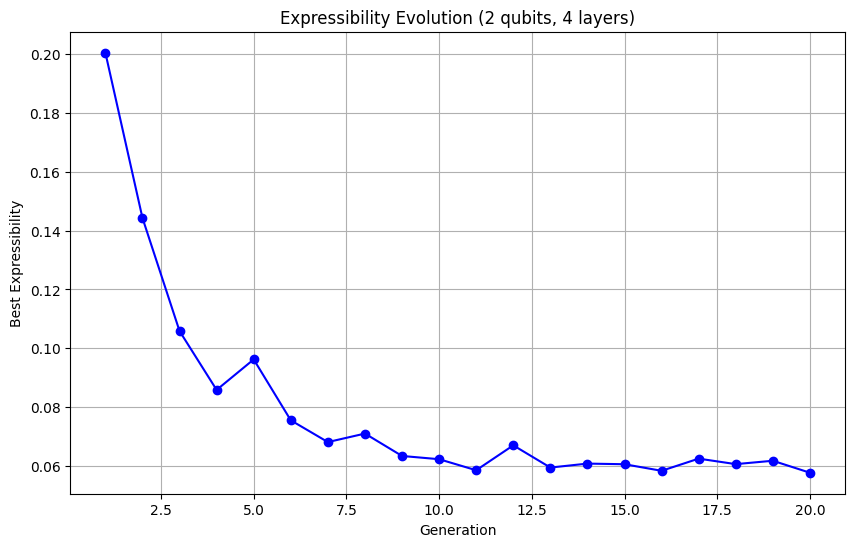

All evolutions complete. Results saved to quantum_circuit_results_Setb


In [11]:
if __name__ == "__main__":
    main()